In [1]:
import torch
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as T
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Load the test data
test_ds = COCO('../data/coco_dataset_test.json')

#Load the category names
NYU40CLASSES = ['void',
                'wall', 'floor', 'cabinet', 'bed', 'chair',
                'sofa', 'table', 'door', 'window', 'bookshelf',
                'picture', 'counter', 'blinds', 'desk', 'shelves',
                'curtain', 'dresser', 'pillow', 'mirror', 'floor_mat',
                'clothes', 'ceiling', 'books', 'refridgerator', 'television',
                'paper', 'towel', 'shower_curtain', 'box', 'whiteboard',
                'person', 'night_stand', 'toilet', 'sink', 'lamp',
                'bathtub', 'bag', 'otherstructure', 'otherfurniture', 'otherprop']

# Create a dictionary that maps category IDs to category names
id_to_name = {i: name for i, name in enumerate(NYU40CLASSES)}

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [2]:
while True:
    img_id = random.choice(list(test_ds.imgs.keys()))

    # Get the ground truth bounding boxes and their categories for this image
    gt_annotations = test_ds.loadAnns(test_ds.getAnnIds(img_id))
    gt_boxes = [ann['bbox'] for ann in gt_annotations]
    gt_classes = [ann['category_id'] for ann in gt_annotations]

    nr_nonvoid_detections = len([ann['category_id'] for ann in gt_annotations if ann['category_id'] != 0])
    if nr_nonvoid_detections > 4:
        break

img_info = test_ds.loadImgs(img_id)[0]
im = Image.open(img_info['file_name']).convert('RGB')

#check if any void class is present
if 0 in gt_classes:
    print("Image contains void class")
    
image_tensor = F.to_tensor(im).unsqueeze(0).to(device)

In [3]:
#Load the pretrained RESNET model
def get_model_resnet(num_classes, state_dict):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(state_dict))
    model.eval()
    return model

# Fix the state dict
resnet = get_model_resnet(41, 'resnet.pth')
resnet.to(device)

prediction_resnet = resnet(image_tensor)

/home/gijsf/miniconda3/envs/Im3D/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811792945/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
#Load the pretrained mobilenet model
def get_model_mobilenet(num_classes, state_dict):
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(state_dict))
    model.eval()
    return model

# Fix the state dict
mobilenet = get_model_mobilenet(41, 'mobilenet.pth')
mobilenet.to(device)

prediction_mobilenet = mobilenet(image_tensor)

In [5]:
#Load the pretrained DETR model
def get_model(state_dict):
    # Load the pre-trained model with the original number of classes
    model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=False)

    # Define a new classification head
    num_in_features = model.class_embed.in_features
    num_output_features = len(NYU40CLASSES) + 1 # Define your number of output features here

    # Replace the classification head
    model.class_embed = torch.nn.Linear(num_in_features, num_output_features)
    model.load_state_dict(torch.load(state_dict))
    model.eval()
    return model

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def filter_close_bboxes(scores, boxes):
    # Filter out the bounding boxes that are too close to each other
    # Keep the maximum score for any overlapping bounding box
    keep_boxes = []
    keep_scores = []
    
    for i in range(len(boxes)):
        box = boxes[i]
        x1, y1, x2, y2 = box
        close_indices = []
        
        # Check if the box is close to any already kept box
        for j, kept_box in enumerate(keep_boxes):
            x3, y3, x4, y4 = kept_box
            dif = 30
            if abs(x1 - x3) <= dif and abs(y1 - y3) <= dif and abs(x2 - x4) <= dif and abs(y2 - y4) <= dif:
                close_indices.append(j)
        
        # If the box is close to existing boxes, average them and take the maximum score
        if close_indices:
            all_close_boxes = [keep_boxes[j] for j in close_indices] + [box]
            all_close_scores = [keep_scores[j] for j in close_indices] + [scores[i]]
            avg_box = np.mean(all_close_boxes, axis=0)
            max_score = max(all_close_scores)
            # Replace all close boxes and scores with their average and max score
            for j in sorted(close_indices, reverse=True):
                del keep_boxes[j]
                del keep_scores[j]
            keep_boxes.append(avg_box)
            keep_scores.append(max_score)
        else:
            keep_boxes.append(box)
            keep_scores.append(scores[i])
    
    print(f"Original number of boxes: {len(boxes)}\n Number of boxes after filtering: {len(keep_boxes)}")
    return keep_scores, keep_boxes

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    scores, boxes = filter_close_bboxes(probas[keep], bboxes_scaled)
    return scores, boxes

detr = get_model('detr.pth')
detr_success = False   
try:
    detr_scores, detr_boxes = detect(im, detr, transform)
    detr_success = True
except Exception as e:
    print(e)
    print("DETR FAILED")
    detr_scores = []
    detr_boxes = []

Using cache found in /home/gijsf/.cache/torch/hub/facebookresearch_detr_main


Original number of boxes: 1
 Number of boxes after filtering: 1


/home/gijsf/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


Image ID:  270
DETR Success:  True


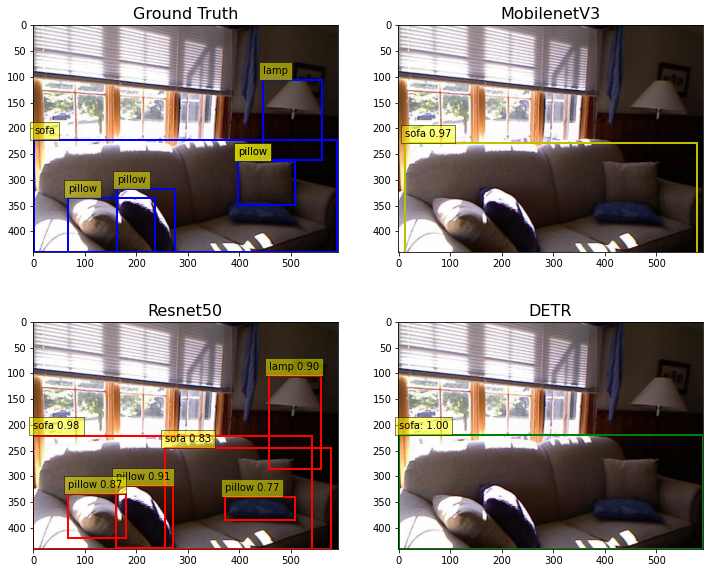

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
print('Image ID: ', img_id)
print('DETR Success: ', detr_success)
# Draw the image and the ground truth bounding boxes on the first subplot
ax[0, 0].imshow(im)
for box, category_id in zip(gt_boxes, gt_classes):
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='b', facecolor='none')
    ax[0, 0].add_patch(rect)
    ax[0, 0].text(box[0], max(30, box[1] - 12), id_to_name[category_id], fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))
ax[0, 0].set_title('Ground Truth', fontsize=16)

# Draw the outputs of the model on the second subplot
ax[0, 1].imshow(im)
for box, category_id, score in zip(prediction_mobilenet[0]['boxes'], prediction_mobilenet[0]['labels'], prediction_mobilenet[0]['scores']):
    if score > 0.7:
        # Detach the box tensor and convert it to a NumPy array
        box = box.detach().cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='y', facecolor='none')
        ax[0, 1].add_patch(rect)
        ax[0, 1].text(box[0], max(30, box[1] - 12), id_to_name[category_id.item()] + f' {score:.2f}', fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
ax[0, 1].set_title('MobilenetV3', fontsize=16)

# Draw the outputs of the model on the third subplot
ax[1, 0].imshow(im)
for box, category_id, score in zip(prediction_resnet[0]['boxes'], prediction_resnet[0]['labels'], prediction_resnet[0]['scores']):
    if score > 0.7:
        # Detach the box tensor and convert it to a NumPy array
        box = box.detach().cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax[1, 0].add_patch(rect)
        ax[1, 0].text(box[0], max(30, box[1] - 12), id_to_name[category_id.item()] + f' {score:.2f}', fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
ax[1, 0].set_title('Resnet50', fontsize=16)

ax[1, 1].imshow(im)
for p, (xmin, ymin, xmax, ymax) in zip(detr_scores, detr_boxes):
    # ax[1, 1].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
    #                             fill=False, color=c, linewidth=3))
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none')
    ax[1, 1].add_patch(rect)
    cl = p.argmax()
    text = f'{NYU40CLASSES[cl]}: {p[cl]:0.2f}'
    ax[1, 1].text(xmin, max(30, ymin - 12), text, fontsize=10,
            bbox=dict(facecolor='yellow', alpha=0.5))
ax[1, 1].set_title('DETR', fontsize=16)

if detr_success:
    plt.savefig(f"Comparison_{img_id}.png")
else:
    plt.show()